# Group 9 assignment output

## Introduction: goal and methodology

The goal of the project is to try to explain after-the-fact the price movement of a stock during a day training a text classifier on the financial news headlines of the same day. Following the recomendation in the assignement notebook, we consider this a multilabel classification problem: the input is the string of the concatenated titles for a stock and the output is the class of the price movement (DOWN, FLAT, UP).

We identified four phases:
 - web scraping
 - dataset creation
 - model training
 - model evaluation

Therefore, this notebook is divided in four sections. In the first section, we present the code used to extract the financial headlines: we executed the code every day during the last working week, after the US market had closed so as to have the maximum number of articles published during day and the full daily price variation. In the second, we create and visualise the dataset. It is imbalanced but we decided to not rebalance the dataset as it is not big enough. Finally, in the last two sections, we train different models, we choose one based on performanced on the validation set and test it on the test set.


## Titles extraction

In [ ]:
import urllib.request
import bs4 as bs
import time
import datetime

import pandas as pd
import numpy as np
import yfinance as yf

In [ ]:
t_df = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

num_tickers = 500

tickers = list(t_df["Symbol"][0:num_tickers])

#tickers = ["TSLA",  "EBAY", "META" ]   # for test
#print(tickers)

In [ ]:
#STOCK

sleep_time  = 5

def extract_dates(parsed_doc):
    from math import floor
    today = datetime.datetime.now().date()
    dates = parsed_doc.find_all('pubdate')
    list_date = []
    for date  in dates:
        d = datetime.datetime.strptime( date.text, "%a, %d %b %Y %H:%M:%S GMT" )
        list_date += [floor((today - d.date()).days / 1)]                          #.days
    return list_date


def get_titles(ticker, sleep_time):
    '''
    This function return the url response from google news and parsed html for a stock ticker.
    The time parameter is the sleep time before each request
    '''
    url = 'https://news.google.com/rss/search?hl=en-US&q='+ticker+'%20stock&gl=US&ceid=US:en'

    time.sleep(sleep_time) ## wait 15 seconds between each request. This is SUPER IMPORTANT otherwise your IP-address will be banned for sending too frequent requests.

    doc = urllib.request.urlopen(url).read()
    parsed_doc = bs.BeautifulSoup(doc,'lxml')
    titles = parsed_doc.find_all('title')[1:]
    list_date = extract_dates(parsed_doc)                 # we  assume/have verified that the date are extracted in the same order as the titles
    dct = {"Ticker": [ ticker ]*len(titles) , "Titles" : titles, "Date" : list_date}
    title_df = pd.DataFrame(dct)
    title_df = title_df.sort_values(by="Date")
    title_df = title_df[title_df["Date"]==0]
    return title_df

list_df = []                        #dictionary with input data
for ticker in tickers:
    title = get_titles(ticker, sleep_time)
    list_df.append(title)
    print(title)

#input_df = pd.DataFrame(dct.values(),index = tickers,columns=["Titles"])

In [ ]:
input_df = pd.concat(list_df)
input_df.shape
input_df.head()

In [ ]:
sleep_time = 5
threshold = 0.01

def get_var_prc(ticker, sleep_time):
    tickerData = yf.Ticker(ticker)
    time.sleep(sleep_time)  # Wait between requests
    df = tickerData.history()
    if len(df) < 2:
        print(f"Insufficient data for {ticker}")
        return None
    df['Change'] = df['Close'].diff()
    return df["Change"].iloc[-1] / df["Close"].iloc[-2]  # Use iloc for integer indexing

def get_target(x):
    if x < -threshold:
        return -1
    elif abs(x) < threshold:
        return 0
    else:
        return 1



# Add a new column 'Var_prc' and assign values to it
for ticker in input_df['Ticker']:
    var_prc = get_var_prc(ticker, sleep_time)
    if var_prc is not None:  # Check if data is available
        input_df.loc[input_df["Ticker"] == ticker, 'Var_prc'] = var_prc
        input_df.loc[input_df["Ticker"] == ticker, 'Target'] = input_df[input_df["Ticker"] == ticker]['Var_prc'].apply(get_target)
input_df.sample(n=5)

In [ ]:
today_date = datetime.datetime.today().strftime('%d%m')

filename = f"data_{today_date}_(puntoevirgola).csv"
input_df.to_csv(filename,sep=";")


'data_3105_(puntoevirgola).csv'

## Dataset creation

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#!pip install ktrain
#!pip install sentence_transformers
#!pip install --upgrade transformers==4.37.2     # otherwise ktrain.get_learner() does not work https://github.com/amaiya/ktrain/issues/523

First we import the necessary libraries and load the csv

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import ktrain
from ktrain import text

Now, we want to train our models only on stocks and price variations for which there is a minimum number of headlines. To choose the minimum number of headlines T, we plot the distribution of samples across targets for different choices of T.

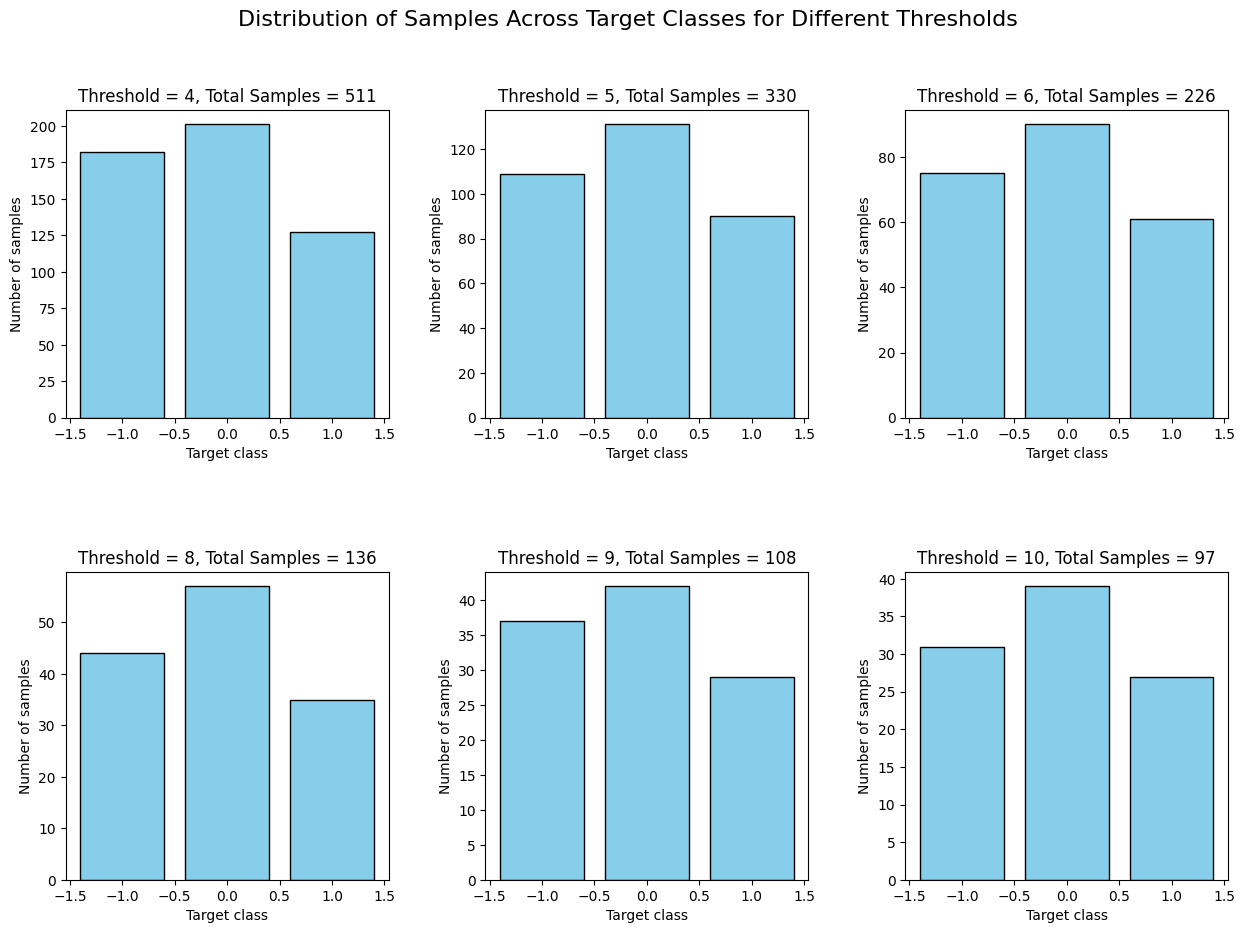

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# parameters to read the data
file_list_1 = ["/data_2805(puntoevirgola).csv", "/data_2905(puntoevirgola).csv","/data_3005(puntoevirgola).csv","/data_3105(puntoevirgola).csv"]
#path = "/content/drive/MyDrive/0.CARMAN_PROJECT/Friday_update_21_50/Data"      #path to Data folder
path = "Data/"
file_list_1 = [ path+s for s in file_list_1 ]

# target values
target = [-1, 0, 1]
# input dataframe columns
col = ["Ticker"] + ["Article " + str(i + 1) for i in range(10)] + ["Target"] + ["Concatenated Titles"]

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.3)  # Adjust spacing between subplots

# we iterate over the thresholds
threshold = [4,5, 6, 8, 9, 10]
for i, T in enumerate(threshold):
    row_index = i // 3   # parameters for visualization
    col_index = i % 3

    # DataFrame initialization for each threshold
    all_data_set = pd.DataFrame(columns=col)

    # we iterate over the files to create the input dataframe
    for file_name in file_list_1:
        # we read the file
        data_set = pd.read_csv(file_name, sep=";")
        input_df = pd.DataFrame(columns=col)

        for ticker in data_set["Ticker"].unique():
            # we etract all the headlines related to a stock during a day
            ticker_df = data_set[data_set["Ticker"] == ticker]
            articles_list = ticker_df["Titles"].to_list()

            # and we add a row to the input dataframe only if there are enough articles
            if len(articles_list) >= T:
                ticker_target = ticker_df["Target"].iloc[0]
                new_row = [ticker] + articles_list[0:T] + [""] * (10 - T) + [ticker_target] + [" ".join(articles_list)]
                input_df.loc[len(input_df.index)] = new_row
        all_data_set = pd.concat([all_data_set, input_df], ignore_index=True)

    # Plot the distribution of samples for the current threshold
    ax = axes[row_index, col_index]
    ax.bar(target, [all_data_set[all_data_set["Target"] == t].shape[0] for t in target], color='skyblue',
           edgecolor='black')
    ax.set_xlabel('Target class')
    ax.set_ylabel('Number of samples')
    ax.set_title('Threshold = ' + str(T) + ", Total Samples = " + str(all_data_set.shape[0]))

# Add a common title for all subplots
fig.suptitle('Distribution of Samples Across Target Classes for Different Thresholds', fontsize=16)

plt.show()


It is clear that there is a tradeoff between the size of the threshold and the number of samples: we decided that a threshold of four is the minimum that we can consider.

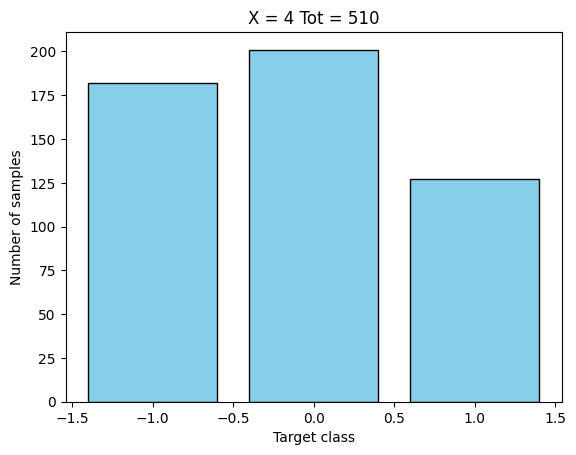

[182, 201, 127]


,Ticker,Article 1,Article 2,Article 3,Article 4,Article 5,Article 6,Article 7,Article 8,Article 9,Article 10,Target,Concatenated Titles
34,ED,When (ED) Moves Investors should Listen - Stoc...,EverSource Wealth Advisors LLC Sells 256 Share...,Subscriptions open for Abu Dhabi's Alef Educat...,"As Alef IPO opens, is education going to be ne...",,,,,,,-1.0,When (ED) Moves Investors should Listen - Stoc...
241,MKTX,MarketAxess Holdings Inc. stock outperforms co...,Is MarketAxess Holdings (MKTX) Stock Outpacing...,MarketAxess Holdings Inc. (NASDAQ:MKTX) Shares...,"3 Stocks on Sale: MRNA, BLDR, and MKTX - Bayst...",,,,,,,-1.0,MarketAxess Holdings Inc. stock outperforms co...
91,NFLX,Netflix Stock Gets Price Target Hike On Plan C...,Netflix (NASDAQ:NFLX) Price Target Increased t...,"Netflix, Inc. (NASDAQ:NFLX) Shares Purchased b...",Netflix To Rally Over 8%? Here Are 10 Top Anal...,,,,,,,0.0,Netflix Stock Gets Price Target Hike On Plan C...


In [ ]:
 # same code from before
all_data_set = pd.DataFrame(columns=col)
T = 4
for file_name in file_list_1:
    data_set = pd.read_csv(file_name, sep=";")
    input_df = pd.DataFrame(columns=col)
    for ticker in data_set["Ticker"].unique():
        ticker_df = data_set[data_set["Ticker"] == ticker]
        articles_list = ticker_df["Titles"].to_list()
        if len(articles_list) >= T:
            articles_list = articles_list[:T]
            ticker_target = ticker_df["Target"].iloc[0]
            new_row = [ticker] + articles_list + [""] * (10 - T) + [ticker_target] + [" ".join(articles_list)]
            input_df.loc[len(input_df.index)] = new_row
    all_data_set = pd.concat([all_data_set, input_df], ignore_index=True)
# Cleaning the columns
for i in range(1, 11):
    column_name = f'Article {i}'
    all_data_set[column_name] = all_data_set[column_name].str.replace('<title>', '').str.replace('</title>', '')
all_data_set["Concatenated Titles"] = all_data_set["Concatenated Titles"].str.replace('<title>', '').str.replace('</title>', '')

input_df = all_data_set

input_df = input_df.dropna()
'''
# if we want to rebalance the dataset
num_rows_to_keep = max(all_data_set[all_data_set["Target"] == 1].shape[0], all_data_set[all_data_set["Target"] == -1].shape[0])

subset_to_keep = all_data_set[all_data_set["Target"] == 0].sample(n = num_rows_to_keep)
input_df = pd.concat([subset_to_keep,all_data_set[all_data_set["Target"] == 1],all_data_set[all_data_set["Target"] == -1]])

'''
plt.bar( target ,[input_df[input_df["Target"] == t ].shape[0] for t in target], color='skyblue', edgecolor='black')

plt.xlabel('Target class')
plt.ylabel('Number of samples')
plt.title('X = '+ str(T)+" Tot = " +str(input_df.shape[0]))

plt.show()
print([input_df[input_df["Target"] == t ].shape[0] for t in target])
input_df.sample(n=3)

Now we divide the dataset in training set, validation set and test set

In [ ]:
from sklearn.model_selection import train_test_split

X = input_df.filter(["Concatenated Titles"],axis=1)
Y = input_df.filter(["Target"],axis=1)
#print(Y)

x_train, x_test, y_train, y_test = train_test_split( X, Y, test_size=0.20, random_state=42)
x_train, x_val, y_train, y_val = train_test_split( x_train, y_train, test_size=0.20, random_state=42)

y_train = y_train + 1
y_test = y_test + 1
y_val = y_val + 1

## Model training and validation

We present three text classifiers:
 - a bert model,
 - a distilroberta concatenated with a neural network
 - a Text2Vec model concatenated with a neural network. \

The bert model has been the first model we trained: we noticed that a problem is that the transformer accepts strings of 500 maximum characters. So, we dealt with that in two different ways: in the second model we used a distilroberta finetuned for financial sentiment anlalysis to trasform the headlines in a binary array, and in the last model we generate a embedding of the concatenated headlines unsing a Text2vec model.

### bert-base-multilingual-uncased

As mentioned above, the input of the model is the string of the concatenated headlines. We consider this model as the benchmark as we apply exacly the steps we have seen in class:
 - we obtain the transformer to preprocess the data
 - we find the optimal learning rate
 - we train the classifier
 - we evaluate the performance on the validation set

In [ ]:
model_name = 'bert-base-multilingual-uncased'
transformer = text.Transformer(model_name, maxlen=500, class_names= np.array([0,1,2]))

In [ ]:
processed_train = transformer.preprocess_train(list(x_train["Concatenated Titles"]), list(y_train["Target"]))
processed_val = transformer.preprocess_test(list(x_val["Concatenated Titles"]), list(y_val["Target"]))

preprocessing train...
language: en
train sequence lengths:
	mean : 55
	95percentile : 68
	99percentile : 74


c:\Users\volpe\anaconda3\envs\kt\lib\site-packages\ktrain\utils.py:769: UserWarning: class_names implies classification but targets array contains float(s) instead of integers or strings
  "class_names implies classification but targets array contains float(s) instead of integers or strings"


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 55
	95percentile : 64
	99percentile : 69


In [ ]:
model = transformer.get_classifier()
batch_size = 5
learner = ktrain.get_learner(model, train_data=processed_train, val_data=processed_val, batch_size=batch_size)

simulating training for different learning rates... this may take a few moments...
65/65 [==============================] - 821s 12s/step - loss: 32.8490 - accuracy: 0.3415


c:\Users\volpe\anaconda3\envs\kt\lib\site-packages\ktrain\lroptimize\lrfinder.py:267: UserWarning: Shape of array too small to calculate a numerical gradient, at least (edge_order + 1) elements are required.
  warnings.warn(str(e))




done.
Visually inspect loss plot and select learning rate associated with falling loss


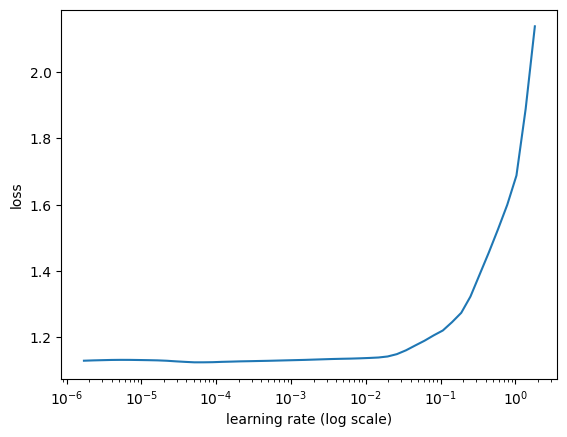

In [ ]:
learner.lr_find(show_plot=True,  max_epochs=1)

In [ ]:
learner.fit_onecycle(1e-5, 2)



begin training using onecycle policy with max lr of 1e-05...
Epoch 1/2
66/66 [==============================] - 877s 13s/step - loss: 1.2155 - accuracy: 0.2515 - val_loss: 1.2152 - val_accuracy: 0.2073
Epoch 2/2
66/66 [==============================] - 849s 13s/step - loss: 1.1403 - accuracy: 0.3558 - val_loss: 1.1532 - val_accuracy: 0.3293


In [ ]:
learner.validate(class_names=transformer.get_classes())

2/2 [==============================] - 1s 275ms/step
              precision    recall  f1-score   support

           0       0.48      1.00      0.64        29
           1       0.00      0.00      0.00        27
           2       0.00      0.00      0.00         5

    accuracy                           0.48        61
   macro avg       0.16      0.33      0.21        61
weighted avg       0.23      0.48      0.31        61



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[29,  0,  0],
       [27,  0,  0],
       [ 5,  0,  0]])

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=transformer)
y_val_pred_labels  = np.zeros( x_val.shape[0])
for i in range(x_val.shape[0]):
    y_val_pred_labels[i] = predictor.predict(x_val["Concatenated Titles"].iloc[i])

y_val_pred_labels

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

It always predicts class DOWN... not really good

### distilroberta-finetuned

Here we use a pre-trained model to get a sentiment label for each headline and use that to generate an embedding used to train a neural network.

In [ ]:
from sklearn.model_selection import train_test_split

articles_list = [ f"Article {i+1}" for i in range(T) ]
X_2 = input_df.filter(articles_list,axis=1)
Y = input_df.filter(["Target"],axis=1)

# we re-divide training , validation and test set beacuse X here is different, putting the same random state we should still get the same division.
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split( X_2, Y, test_size=0.20, random_state=42)
x_train_2, x_val_2,  y_train_2, y_val_2 = train_test_split( x_train_2, y_train_2, test_size=0.20, random_state=42)

y_train_2 = y_train_2 + 1
y_test_2 = y_test_2 + 1
y_val_2 = y_val_2+ 1

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-classification", model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
# Pipeline use example
'''
i = np.random.randint(X.shape[0])
s = X.iloc[i].to_list()
print(s[2])
print(pipe( s[2] )[0]["label"])
'''
def get_label(s):
    return pipe( s )[0]["label"]

Here we create a one hot encoding of the sentiment for each title

In [ ]:
map_label_encoding = { "positive": np.array([0,0,1]), "neutral": np.array([0,1,0]),"negative": np.array([1,0,0]) }
num_sentiment = 3

# training input encoding
x_train_2_ones = np.zeros( (x_train_2.shape[0],T*num_sentiment))

for row_idx in range(x_train_2.shape[0]):
    articles_list = x_train_2.iloc[i].to_list()
    for i in range(len(articles_list)):    # len(s) = T
        x_train_2_ones[row_idx,i*3:i*3+3] = map_label_encoding[ get_label(articles_list[i])]

# validation input encoding
x_val_2_ones = np.zeros( (x_val_2.shape[0],T*num_sentiment))

for row_idx in range(x_val_2.shape[0]):
    articles_list = x_val_2.iloc[i].to_list()
    for i in range(len(articles_list)):    # len(s) = T
        x_val_2_ones[row_idx,i*3:i*3+3] = map_label_encoding[ get_label(articles_list[i])]

# test input encoding
x_test_2_ones = np.zeros( (x_test_2.shape[0],T*num_sentiment))

for row_idx in range(x_test_2.shape[0]):
    articles_list = x_test_2.iloc[i].to_list()
    for i in range(len(articles_list)):    # len(s) = T
        x_test_2_ones[row_idx,i*3:i*3+3] = map_label_encoding[ get_label(articles_list[i])]

x_train_2_ones[0]

array([0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1.])

In [ ]:
#to train the NN we need to convert integer output to binary array
num_classes = 3

y_train_dummy_2 = np.zeros((len(y_train_2), num_classes))
for i in range(0,len(y_train_2)):
    class_idx = round(y_train_2.Target.iloc[i])
    y_train_dummy_2[i, class_idx] = 1


y_val_dummy_2 = np.zeros((len(y_val_2), num_classes))
for i in range(0,len(y_val_2)):
  y_val_dummy_2[i,round(y_val_2.Target.iloc[i])] = 1

y_test_dummy_2 = np.zeros((len(y_test_2), num_classes))
for i in range(0,len(y_test_2)):
  y_test_dummy_2[i,round(y_test_2.Target.iloc[i])] = 1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

In [ ]:
# Here we create several NN architechtures

def create_m1(epo,lr,bat,x,y):
    model=Sequential()
    model.add(Dense(units=30, activation='relu', input_dim=c))
    model.add(Dense(units=100, activation='tanh'))
    model.add(Dense(units=3, activation='sigmoid'))    #output layer
    model.compile(loss='mse',                                    # tf.keras.losses.CategoricalCrossentropy should be more appropriate but I cannot make it work
                  optimizer=Adam(lr=lr,beta_1=0.9,beta_2=0.999))
    model.fit(x,y,epochs=epo,batch_size=bat,verbose=0)
    return model
def create_m2(epo,lr,bat,x,y):
    model=Sequential()
    model.add(Dense(units=30, activation='relu', input_dim=c))
    model.add(Dense(units=3, activation='sigmoid'))    #output layer
    model.compile(loss='mse',
                  optimizer=Adam(lr=lr,beta_1=0.9,beta_2=0.999))
    model.fit(x,y,epochs=epo,batch_size=bat,verbose=0)
    return model

def create_m3(epo,lr,bat,x,y):
    model=Sequential()
    model.add(Dense(units=300, activation='relu', input_dim=c))
    model.add(Dense(units=3, activation='sigmoid'))    #output layer
    model.compile(loss='mse',
                  optimizer=Adam(lr=lr,beta_1=0.9,beta_2=0.999))
    model.fit(x,y,epochs=epo,batch_size=bat,verbose=0)
    return model
def create_m4(epo,lr,bat,x,y):
    model=Sequential()
    model.add(Dense(units=900, activation='relu', input_dim=c))
    model.add(Dense(units=50, activation='tanh'))
    model.add(Dense(units=3, activation='sigmoid'))    #output layer
    model.compile(loss='mse',
                  optimizer=Adam(lr=lr,beta_1=0.9,beta_2=0.999))
    model.fit(x,y,epochs=epo,batch_size=bat,verbose=0)
    return model

def get_validation_missclas(y_pred, target):
    return np.sum(y_pred != target) / len(target)


In [ ]:
fun_lst = [create_m1,create_m2,create_m3,create_m4]
epo_list = [1,2,3, 5,10,20,100,150]
lr = 0.001                              # values between 0.001 and 0.0001 should be fine
batch_size_list = [5,8,10,20]
best_performance = 10
# 80 models will be trained
for function in fun_lst:
    for epo in epo_list:
        for bat in batch_size_list:
            model = function(epo,lr,bat,x_train_2_ones,y_train_dummy_2)
            pred_val_raw=model.predict(x_val_2_ones)
            pred_val = np.argmax(pred_val_raw, axis=1)
            miss = get_validation_missclas(pred_val, np.argmax(y_val_dummy_2, axis=1))
            if miss < best_performance:
                best_performance = miss
                opt_model, opt_fun, opt_epo, opt_bat = model, function, epo, bat

In [ ]:
print("Lowest missclassification: ",best_performance,\
      "Optimal model: ",opt_fun, \
      "Optimal number of epoch: ",opt_epo,\
      "Optimal batch size: ", opt_bat,sep="\n")
predictions = opt_model.predict(x_val_2_ones)

Lowest missclassification: 
0.5365853658536586
Optimal model: 
<function create_m1 at 0x000002A3DABE2F78>
Optimal number of epoch: 
1
Optimal batch size: 
8
3/3 [==============================] - 0s 1ms/step


Now that we have chosen the architechture we just have to evaluate the model

4/4 [==============================] - 0s 1ms/step
Precision (train): 0.13549625503406226
Recall (train): 0.36809815950920244
F1-score (train): 0.19807972709015376
Precision (val): 0.2147531231409875
Recall (val): 0.4634146341463415
F1-score (val): 0.2934959349593496
Precision (test): 0.1777201076509035
Recall (test): 0.4215686274509804
F1-score (test): 0.2500338066260987
MSE_train: 0.21981015393245038
MSE_val: 0.2190483007121516
MSE_test: 0.21994343165162833
MSE_train (binary): 0.4212678936605317
MSE_val (binary): 0.35772357723577236
MSE_test (binary): 0.38562091503267976
Misclassification_train: 0.6319018404907976
Misclassification_val: 0.5365853658536586
Misclassification_test: 0.5784313725490197


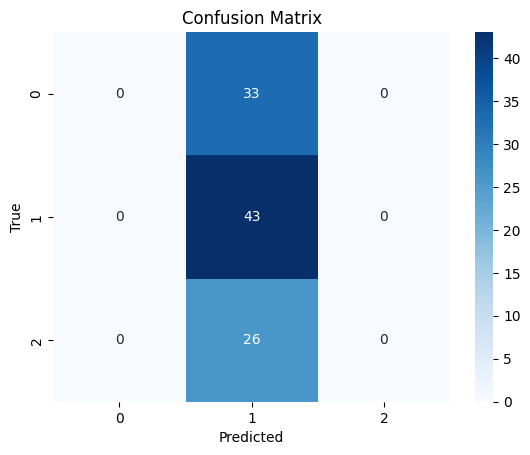

In [ ]:
model  = opt_model
# Install whichever package or library is missing for you
#!pip install sentence-transformers
#!pip install numpy pandas scikit-learn seaborn matplotlib keras
#import pandas as pd
#import numpy as np
#import tensorflow as tf
import seaborn as sns
#import matplotlib.pyplot as plt
#import random as rand
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.optimizers import Adam
#from sentence_transformers import SentenceTransformer
#from transformers import TFBertForSequenceClassification, BertTokenizer, BertConfig
#from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Making predictions
pred_train = model.predict(x_train_2_ones)
pred_val = model.predict(x_val_2_ones)
pred_test = model.predict(x_test_2_ones)

# Converting predictions to binary arrays
def to_binary(pred):
    pred_binary = np.zeros(pred.shape)
    for i in range(len(pred)):
        pred_binary[i, pred[i, :].argmax()] = 1
    return pred_binary

pred_train_2 = to_binary(pred_train)
pred_val_2 = to_binary(pred_val)
pred_test_2 = to_binary(pred_test)

# Converting predictions to class labels
y_train_pred_labels = np.argmax(pred_train, axis=1)
y_val_pred_labels = np.argmax(pred_val, axis=1)
y_test_pred_labels = np.argmax(pred_test, axis=1)

# Converting one-hot encoded true labels to class labels
y_train_true_labels = np.argmax(y_train_dummy_2, axis=1)
y_val_true_labels = np.argmax(y_val_dummy_2, axis=1)
y_test_true_labels = np.argmax(y_test_dummy_2, axis=1)

# Evaluating the model (precision, recall, F1-score, MSE, misclassification and confusion matrix)

# Presicison, recall and F1-Score
def evaluate_performance(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    return precision, recall, f1

precision_train, recall_train, f1_train = evaluate_performance(y_train_true_labels, y_train_pred_labels)
precision_val, recall_val, f1_val = evaluate_performance(y_val_true_labels, y_val_pred_labels)
precision_test, recall_test, f1_test = evaluate_performance(y_test_true_labels, y_test_pred_labels)

print("Precision (train):", precision_train)
print("Recall (train):", recall_train)
print("F1-score (train):", f1_train)

print("Precision (val):", precision_val)
print("Recall (val):", recall_val)
print("F1-score (val):", f1_val)

print("Precision (test):", precision_test)
print("Recall (test):", recall_test)
print("F1-score (test):", f1_test)

# Mean Squared Error and misclassification rate
def mean_squared_error(y_true, y_pred):
    return np.mean((y_pred - y_true) ** 2)

MSE_train = mean_squared_error(y_train_dummy_2, pred_train)
MSE_val = mean_squared_error(y_val_dummy_2, pred_val)
MSE_test = mean_squared_error(y_test_dummy_2, pred_test)

print("MSE_train:", MSE_train)
print("MSE_val:", MSE_val)
print("MSE_test:", MSE_test)

MSE_train_2 = mean_squared_error(y_train_dummy_2, pred_train_2)
MSE_val_2 = mean_squared_error(y_val_dummy_2, pred_val_2)
MSE_test_2 = mean_squared_error(y_test_dummy_2, pred_test_2)

print("MSE_train (binary):", MSE_train_2)
print("MSE_val (binary):", MSE_val_2)
print("MSE_test (binary):", MSE_test_2)


def misclassification_rate(y_true, y_pred):
    #return np.mean(np.abs(y_pred - y_true) / 2)
    return np.sum(y_pred != y_true) / y_true.shape[0]


miss_train = misclassification_rate(y_train_dummy_2.argmax(axis=1), pred_train_2.argmax(axis=1))
miss_val = misclassification_rate(y_val_dummy_2.argmax(axis=1), pred_val_2.argmax(axis=1))
miss_test = misclassification_rate(y_test_dummy_2.argmax(axis=1), pred_test_2.argmax(axis=1))

print("Misclassification_train:", miss_train)
print("Misclassification_val:", miss_val)
print("Misclassification_test:", miss_test)

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test_true_labels, y_test_pred_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Text2vec-base-multilingual

Here we use the sentence transformer to generate an embedding of the concatenated headlines that we use to train a neural network

In [ ]:
from sentence_transformers import SentenceTransformer

model_name = 'shibing624/text2vec-base-multilingual'
m = SentenceTransformer(model_name)

In [ ]:
c = len(m.encode("I love embeddings!"))                   # dim embedding
r = x_train.shape[0]    # dim dataset

x_train_emb = np.zeros((r,c))
for idx in range(r):
  sentence_embeddings = m.encode(x_train.iloc[idx,:].loc["Concatenated Titles"])
  x_train_emb[idx,:] = sentence_embeddings



r = x_val.shape[0]    # dim dataset
x_val_emb = np.zeros((r,c))
for idx in range(r):
  sentence_embeddings = m.encode(x_val.iloc[idx,:].loc["Concatenated Titles"])
  x_val_emb[idx,:] = sentence_embeddings


r = x_test.shape[0]    # dim dataset
x_test_emb = np.zeros((r,c))
for idx in range(r):
  sentence_embeddings = m.encode(x_test.iloc[idx,:].loc["Concatenated Titles"])
  x_test_emb[idx,:] = sentence_embeddings

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

In [ ]:
#to train the NN we need to convert integer output to binary array
num_classes = 3

y_train_dummy = np.zeros((len(y_train), num_classes))
for i in range(0,len(y_train)):
    class_idx = round(y_train.Target.iloc[i])
    y_train_dummy[i, class_idx] = 1


y_val_dummy = np.zeros((len(y_val), num_classes))
for i in range(0,len(y_val)):
  y_val_dummy[i,round(y_val.Target.iloc[i])] = 1

y_test_dummy = np.zeros((len(y_test), num_classes))
for i in range(0,len(y_test)):
  y_test_dummy[i,round(y_test.Target.iloc[i])] = 1

In [ ]:
def create_m1(epo,lr,bat,x,y):
    model=Sequential()
    model.add(Dense(units=30, activation='relu', input_dim=c))
    model.add(Dense(units=100, activation='tanh'))
    model.add(Dense(units=3, activation='sigmoid'))    #output layer
    model.compile(loss='mse',                                    # tf.keras.losses.CategoricalCrossentropy should be more appropriate but I cannot make it work
                  optimizer=Adam(lr=lr,beta_1=0.9,beta_2=0.999))
    model.fit(x,y,epochs=epo,batch_size=bat,verbose=0)
    return model
def create_m2(epo,lr,bat,x,y):
    model=Sequential()
    model.add(Dense(units=30, activation='relu', input_dim=c))
    model.add(Dense(units=3, activation='sigmoid'))    #output layer
    model.compile(loss='mse',
                  optimizer=Adam(lr=lr,beta_1=0.9,beta_2=0.999))
    model.fit(x,y,epochs=epo,batch_size=bat,verbose=0)
    return model

def create_m3(epo,lr,bat,x,y):
    model=Sequential()
    model.add(Dense(units=300, activation='relu', input_dim=c))
    model.add(Dense(units=3, activation='sigmoid'))    #output layer
    model.compile(loss='mse',
                  optimizer=Adam(lr=lr,beta_1=0.9,beta_2=0.999))
    model.fit(x,y,epochs=epo,batch_size=bat,verbose=0)
    return model
def create_m4(epo,lr,bat,x,y):
    model=Sequential()
    model.add(Dense(units=900, activation='relu', input_dim=c))
    model.add(Dense(units=50, activation='tanh'))
    model.add(Dense(units=3, activation='sigmoid'))    #output layer
    model.compile(loss='mse',
                  optimizer=Adam(lr=lr,beta_1=0.9,beta_2=0.999))
    model.fit(x,y,epochs=epo,batch_size=bat,verbose=0)
    return model

def get_validation_missclas(y_pred, target):
    return np.sum(y_pred != target) / len(target)


In [ ]:
fun_lst = [create_m1,create_m2,create_m3,create_m4]
epo_list = [3, 5,10,20,100]
lr = 0.001                              # values between 0.001 and 0.0001 should be fine
batch_size_list = [5,8,10,20]
best_performance = 10
# 80 models will be trained
for function in fun_lst:
    for epo in epo_list:
        for bat in batch_size_list:
            model = function(epo,lr,bat,x_train_emb,y_train_dummy)
            pred_val_raw=model.predict(x_val_emb)
            pred_val = np.argmax(pred_val_raw, axis=1)
            miss = get_validation_missclas(pred_val, np.argmax(y_val_dummy, axis=1))
            if miss < best_performance:
                best_performance = miss
                opt_model, opt_fun, opt_epo, opt_bat = model, function, epo, bat

c:\Users\volpe\anaconda3\envs\kt\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3/3 [==============================] - 0s 2ms/step


In [ ]:
print(best_performance, opt_model, opt_fun, opt_epo, opt_bat,sep="\n")
predictions = opt_model.predict(x_test_emb)

0.4878048780487805
<function create_m2 at 0x000002A3DC771CA8>
100
8
4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 1ms/step
Precision (train): 0.9969578664503371
Recall (train): 0.9969325153374233
F1-score (train): 0.9969296953276707
Precision (val): 0.5289470233412011
Recall (val): 0.5121951219512195
F1-score (val): 0.5148807214477236
Precision (test): 0.3496413199426112
Recall (test): 0.3627450980392157
F1-score (test): 0.3535769967995032
MSE_train: 0.0095456542942512
MSE_val: 0.2786381172321595
MSE_test: 0.30535543746198107
MSE_train (binary): 0.002044989775051125
MSE_val (binary): 0.3252032520325203
MSE_test (binary): 0.42483660130718953
Misclassification_train: 0.003067484662576687
Misclassification_val: 0.4878048780487805
Misclassification_test: 0.6372549019607843


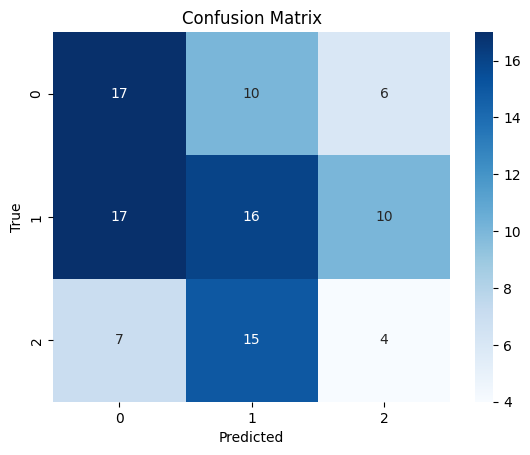

In [ ]:
model  = opt_model
# Install whichever package or library is missing for you
#!pip install sentence-transformers
#!pip install numpy pandas scikit-learn seaborn matplotlib keras
#import pandas as pd
#import numpy as np
#import tensorflow as tf
import seaborn as sns
#import matplotlib.pyplot as plt
#import random as rand
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.optimizers import Adam
#from sentence_transformers import SentenceTransformer
#from transformers import TFBertForSequenceClassification, BertTokenizer, BertConfig
#from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Making predictions
pred_train = model.predict(x_train_emb)
pred_val = model.predict(x_val_emb)
pred_test = model.predict(x_test_emb)

# Converting predictions to binary arrays
def to_binary(pred):
    pred_binary = np.zeros(pred.shape)
    for i in range(len(pred)):
        pred_binary[i, pred[i, :].argmax()] = 1
    return pred_binary

pred_train_2 = to_binary(pred_train)
pred_val_2 = to_binary(pred_val)
pred_test_2 = to_binary(pred_test)

# Converting predictions to class labels
y_train_pred_labels = np.argmax(pred_train, axis=1)
y_val_pred_labels = np.argmax(pred_val, axis=1)
y_test_pred_labels = np.argmax(pred_test, axis=1)

# Converting one-hot encoded true labels to class labels
y_train_true_labels = np.argmax(y_train_dummy, axis=1)
y_val_true_labels = np.argmax(y_val_dummy, axis=1)
y_test_true_labels = np.argmax(y_test_dummy, axis=1)

# Evaluating the model (precision, recall, F1-score, MSE, misclassification and confusion matrix)

# Presicison, recall and F1-Score
def evaluate_performance(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    return precision, recall, f1

precision_train, recall_train, f1_train = evaluate_performance(y_train_true_labels, y_train_pred_labels)
precision_val, recall_val, f1_val = evaluate_performance(y_val_true_labels, y_val_pred_labels)
precision_test, recall_test, f1_test = evaluate_performance(y_test_true_labels, y_test_pred_labels)

print("Precision (train):", precision_train)
print("Recall (train):", recall_train)
print("F1-score (train):", f1_train)

print("Precision (val):", precision_val)
print("Recall (val):", recall_val)
print("F1-score (val):", f1_val)

print("Precision (test):", precision_test)
print("Recall (test):", recall_test)
print("F1-score (test):", f1_test)

# Mean Squared Error and misclassification rate
def mean_squared_error(y_true, y_pred):
    return np.mean((y_pred - y_true) ** 2)

MSE_train = mean_squared_error(y_train_dummy, pred_train)
MSE_val = mean_squared_error(y_val_dummy, pred_val)
MSE_test = mean_squared_error(y_test_dummy, pred_test)

print("MSE_train:", MSE_train)
print("MSE_val:", MSE_val)
print("MSE_test:", MSE_test)

MSE_train_2 = mean_squared_error(y_train_dummy, pred_train_2)
MSE_val_2 = mean_squared_error(y_val_dummy, pred_val_2)
MSE_test_2 = mean_squared_error(y_test_dummy, pred_test_2)

print("MSE_train (binary):", MSE_train_2)
print("MSE_val (binary):", MSE_val_2)
print("MSE_test (binary):", MSE_test_2)


def misclassification_rate(y_true, y_pred):
    #return np.mean(np.abs(y_pred - y_true) / 2)
    return np.sum(y_pred != y_true) / y_true.shape[0]


miss_train = misclassification_rate(y_train_dummy.argmax(axis=1), pred_train_2.argmax(axis=1))
miss_val = misclassification_rate(y_val_dummy.argmax(axis=1), pred_val_2.argmax(axis=1))
miss_test = misclassification_rate(y_test_dummy.argmax(axis=1), pred_test_2.argmax(axis=1))

print("Misclassification_train:", miss_train)
print("Misclassification_val:", miss_val)
print("Misclassification_test:", miss_test)

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test_true_labels, y_test_pred_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Test set and conclusions

Based on the performance on the validation set we choose the model XXXXXXXXXXX because ...